## <span style="color: #ac6aad"> Project 7 - Recommendation Systems (Venkata Harsha Vardhan Chunduri) </span>
## <span style="color: #ac6aad">Objective:  </span>
### Build a recommendation system to recommend products to customers based on the their previous ratings for other products. 

### <span style="color: #ac6aad"> Import necessary libraries </span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split as train_test_split_skl
from sklearn.externals import joblib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as train_test_split_surprise

from colorama import Fore, Back, Style

## <span style="color: #ac6aad">  1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) </span>

In [2]:
electronics_df1 = pd.read_csv("ratings_Electronics.csv")
electronics_df1.columns = ['userId', 'productId', 'Rating', 'timestamp']
electronics_df1.head(5)

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [3]:
print(Fore.BLACK + Back.CYAN + "Shape of given data: " +  Back.WHITE + str(electronics_df1.shape))

Shape of given data: (7824481, 4)


In [4]:
print(Fore.BLACK + Back.CYAN + "Datatypes: ")
electronics_df1.dtypes

Datatypes: 


userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

### <span style="color: #030ffc"> <ul> <li> Visually inspecting the data, there is no presence of missing values. </li> <li> All the ratings are in the range of 1 - 5 (both inclusive) </li> </ul> </span>

In [5]:
# Removing the timestamp attribute and conveting the float to int8 for faster processing

electronics_df2 = electronics_df1.drop(['timestamp'],axis=1,inplace=False)
electronics_df2["Rating"] = electronics_df2["Rating"].astype('int8')
print(Fore.BLACK + Back.CYAN +"Shape of updated data: " +Fore.BLACK + Back.WHITE + str(electronics_df2.shape)) 
print(Fore.BLACK + Back.CYAN +"Datatypes: ")
electronics_df2.dtypes
print(Fore.BLACK + Back.CYAN +"electronics_df2 head: ")
electronics_df2.head(5)

Shape of updated data: (7824481, 3)
Datatypes: 


userId       object
productId    object
Rating         int8
dtype: object

electronics_df2 head: 


,userId,productId,Rating
0,A2CX7LUOHB2NDG,0321732944,5
1,A2NWSAGRHCP8N5,0439886341,1
2,A2WNBOD3WNDNKT,0439886341,3
3,A1GI0U4ZRJA8WN,0439886341,1
4,A1QGNMC6O1VW39,0511189877,5


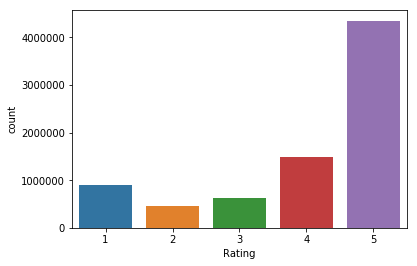

In [6]:
#plotting count of Rating
sns.countplot(data=electronics_df2 , x='Rating')
plt.show()

### <span style="color: #030ffc"> From the above plot, we can see most of the items in the data are having a rating of 5. </span>

## <span style="color: #ac6aad">  2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) </span>

In [7]:
#Finding the number of ratings given by each of the users in the dataframe
Users_counts = electronics_df1['userId'].value_counts()
Users_counts.head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: userId, dtype: int64

In [8]:
# Selecting the records from users who have given at least 50 ratings into a new dataframe 'electronics_df2'
electronics_df3 = electronics_df2[electronics_df2['userId'].isin(Users_counts[Users_counts >= 50].index)]
#Shape of new data
print(Fore.BLACK + Back.CYAN +"Shape of updated data: " +Fore.BLACK + Back.WHITE + str(electronics_df3.shape))
electronics_df3.shape
print(Fore.BLACK + Back.CYAN +"Top 5 rows from dataframe: ")
electronics_df3.head(5)

Shape of updated data: (125871, 3)


(125871, 3)

Top 5 rows from dataframe: 


,userId,productId,Rating
93,A3BY5KCNQZXV5U,0594451647,5
117,AT09WGFUM934H,0594481813,3
176,A32HSNCNPRUMTR,0970407998,1
177,A17HMM1M7T9PJ1,0970407998,4
491,A3CLWR1UUZT6TG,0972683275,5


### <span style="color: #030ffc"> We can see, the total number of records in the new dataframe is 125871. We are going to consider this dataframe for our further analysis. </span>

## <span style="color: #ac6aad">  3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) </span>

In [9]:
train_data, test_data = train_test_split_skl(electronics_df3, test_size = 0.30, random_state=0)

In [10]:
print(Fore.BLACK + Back.CYAN + "Shape of train_data: " +Fore.BLACK + Back.WHITE + str(train_data.shape))
print(Fore.BLACK + Back.CYAN + "Shape of test_data: " +Fore.BLACK + Back.WHITE + str(test_data.shape))

Shape of train_data: (88109, 3)
Shape of test_data: (37762, 3)


## <span style="color: #ac6aad"> 4. Build Popularity Recommender model </span>

### <span style="color: #030ffc"> Going to consider the complete data instead of train set as we are only going to filter the top rated products.</span>

In [11]:
#Grouping the data by product and display the total number of users who rated the product (i.e.., score of each product)
electronics_df3_grouped = electronics_df3.groupby('productId').agg({'userId': 'count'}).reset_index()
electronics_df3_grouped.rename(columns = {'userId': 'score'},inplace=True)
print(Fore.BLACK + Back.CYAN + "Top 5 Products with max number of ratings for each of product: ")
electronics_df3_grouped.head()

Top 5 Products with max number of ratings for each of product: 


,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [12]:
#Sort the products based on recommendation score in ascending order
electronics_df3_sort = electronics_df3_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score and adding it as a new column to train dataframe
electronics_df3_sort['Rank'] = electronics_df3_sort['score'].rank(ascending=0, method='first') 

### <span style="color: #030ffc">  We can see the product with maximum number of ratings gets the highest rank </span>

In [13]:
#Loading the the top 5 recommendations into 'popularity_recommendations' dataset
popularity_recommendations = electronics_df3_sort 
print(Fore.BLACK + Back.CYAN +"Popularity Recommendations: ")
popularity_recommendations.head(5)

Popularity Recommendations: 


,productId,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [14]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations.head(5)

### <span style="color: #030ffc">  This model gives the same recommendation to any user as the recommendations are purely based on popularity (user ratings) and not related to any previous behavior of user </span>

In [15]:
# Finding the recommendations for random users 1, 99 & 157
find_recom = [1,99,157]   # This list is user choice.
for i in find_recom:
    print(Fore.BLACK + Back.CYAN +("Here is the recommendation for the userId: %d\n" %(i)))
    print(Fore.BLACK + Back.WHITE + "\n")
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 1



       userID   productId  score  Rank
39003       1  B0088CJT4U    206   1.0
24827       1  B003ES5ZUU    184   2.0
11078       1  B000N99BBC    167   3.0
38250       1  B007WTAJTO    164   4.0
38615       1  B00829TIEK    149   5.0


Here is the recommendation for the userId: 99



       userID   productId  score  Rank
39003      99  B0088CJT4U    206   1.0
24827      99  B003ES5ZUU    184   2.0
11078      99  B000N99BBC    167   3.0
38250      99  B007WTAJTO    164   4.0
38615      99  B00829TIEK    149   5.0


Here is the recommendation for the userId: 157



       userID   productId  score  Rank
39003     157  B0088CJT4U    206   1.0
24827     157  B003ES5ZUU    184   2.0
11078     157  B000N99BBC    167   3.0
38250     157  B007WTAJTO    164   4.0
38615     157  B00829TIEK    149   5.0




### <span style="color: #030ffc">  As mentioned earlier, we can see the recommendations given by the model are same for all the 3 random users

## <span style="color: #ac6aad">  5.Build Collaborative Filtering model. </soan>

In [16]:
# Initialising the Reader and data for finding the collaborative filtering model using Surprise dataset
#Reader gets initialised for ratings 1-5 by default which is the same as our sample
reader = Reader()
data = Dataset.load_from_df(electronics_df3[['userId', 'productId', 'Rating']], reader)

In [18]:
#Initialising an array to store the results
benchmark = [] 

In [19]:
for algorithm in [SVD()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
        
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.984977,6.386336,0.424088


In [20]:
for algorithm in [KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
        
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [21]:
for algorithm in [BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
        
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [22]:
for algorithm in [ CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
        
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [23]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.981750,0.386932,0.344475
SVD,0.984977,6.386336,0.424088
KNNWithMeans,1.055325,0.758552,0.792557
CoClustering,1.087895,5.613102,0.342803


## <span style="color: #ac6aad">  6.Evaluate both the models </span>

### <span style="color: #ac6aad"> a.Popularity based model gives the top n predictions based on the ratings on products. </span>

### <span style="color: #ac6aad"> b.In Collaborative filtering model, we have evaluated multiple algorithms </span>

In [24]:
print(Fore.BLACK + Back.CYAN +("RMSE, Fit & Test times for algorithms verified in CV"))
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

RMSE, Fit & Test times for algorithms verified in CV


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.981750,0.386932,0.344475
SVD,0.984977,6.386336,0.424088
KNNWithMeans,1.055325,0.758552,0.792557
CoClustering,1.087895,5.613102,0.342803


### <span style="color: #030ffc"> From the above tests, BaselineOnly algorithm gave us the least RMSE, therefore, we will train and predict with BaselineOnly and use Alternating Least Squares (ALS). </span>

### <span style="color: #030ffc">  Lets proceed to apply this model on our train data and compare the RMSE with test data </span>

In [25]:
# Splitting the data into train & test datasets having 30% for test set using surpise library
trainset, testset = train_test_split_surprise(data, test_size=0.30)

In [26]:
print(Fore.BLACK + Back.CYAN + 'Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.98136512, 0.97662738, 0.98107916]),
 'fit_time': (0.19388937950134277, 0.20689988136291504, 0.20290231704711914),
 'test_time': (0.3827981948852539, 0.35077810287475586, 0.3677704334259033)}

In [27]:
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9827


0.9827170231329481

In [28]:
predictions

[Prediction(uid='A3M7BCQKSQAK4L', iid='B009HPC228', r_ui=3.0, est=4.1946986734572045, details={'was_impossible': False}),
 Prediction(uid='A13BX9O5UDBILC', iid='B004FPIO18', r_ui=3.0, est=3.9773811813437336, details={'was_impossible': False}),
 Prediction(uid='A296QED1MV1V0J', iid='B001G445Q4', r_ui=4.0, est=4.34660102964148, details={'was_impossible': False}),
 Prediction(uid='A14JBDSWKPKTZA', iid='B00007KDVK', r_ui=5.0, est=4.411795940612661, details={'was_impossible': False}),
 Prediction(uid='A2W0XCWOK3MW6F', iid='B004CLYEE6', r_ui=5.0, est=4.710533634427306, details={'was_impossible': False}),
 Prediction(uid='A356RFKNIG043B', iid='B0040702HU', r_ui=4.0, est=3.7881489425476498, details={'was_impossible': False}),
 Prediction(uid='ADLVFFE4VBT8', iid='B00923G46U', r_ui=5.0, est=4.175661292716408, details={'was_impossible': False}),
 Prediction(uid='A26BDXG9KVH7SU', iid='B007W7PIZ6', r_ui=5.0, est=3.7153933475042984, details={'was_impossible': False}),
 Prediction(uid='A11FX8HL2ANK6T

In [29]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]


In [30]:
print(Fore.BLACK + Back.CYAN + "Best Prdictions")
best_predictions

Best Prdictions


,uid,iid,rui,est,details,Iu,Ui,err
15664,A3UKWQS8SRW6IO,B009F7IBZK,5.0,5.0,{'was_impossible': False},42,14,0.0
12412,A2TA40MV2H4O6F,B001TH7GUU,5.0,5.0,{'was_impossible': False},43,52,0.0
35562,A3EQQHWJ1EEYEU,B000CRFOMK,5.0,5.0,{'was_impossible': False},31,22,0.0
35557,A2W0XCWOK3MW6F,B009YT6PPC,5.0,5.0,{'was_impossible': False},37,20,0.0
33876,A3RGJ1FXOB1ZLL,B005ES0YYA,5.0,5.0,{'was_impossible': False},59,19,0.0
12456,A1BZIM4WGZ6DZP,B005INZKKE,5.0,5.0,{'was_impossible': False},36,2,0.0
29194,A1Z16630QMH8Q6,B000HPV3RW,5.0,5.0,{'was_impossible': False},70,34,0.0
26776,AKT8TGIT6VVZ5,B0007WK8KS,5.0,5.0,{'was_impossible': False},136,4,0.0
4567,A38C12950IM24P,B00DTZYHX4,5.0,5.0,{'was_impossible': False},63,23,0.0
12498,A3DOPYDOS49I3T,B000O8WE66,5.0,5.0,{'was_impossible': False},68,20,0.0


In [31]:
print(Fore.BLACK + Back.CYAN + "Worst Predictions")
worst_predictions

Worst Predictions


,uid,iid,rui,est,details,Iu,Ui,err
29768,A31ICLWQ9CSHRS,B006JINHYS,1.0,4.878119,{'was_impossible': False},54,21,3.878119
16344,A1YN5I4FINMBTI,B0041OSQ9I,1.0,4.902341,{'was_impossible': False},45,18,3.902341
27107,A680RUE1FDO8B,B0015AARJI,1.0,4.905541,{'was_impossible': False},287,28,3.905541
7171,A19XMHRB3G4DIR,B000W09ZTK,1.0,4.907496,{'was_impossible': False},74,6,3.907496
11329,AHF4I1FSIHABC,B00007E7JU,1.0,4.908658,{'was_impossible': False},49,44,3.908658
31544,AHF4I1FSIHABC,B00182CIB8,1.0,4.927016,{'was_impossible': False},49,11,3.927016
26958,AHF4I1FSIHABC,B006TT91TW,1.0,5.000000,{'was_impossible': False},49,20,4.000000
36261,A1BZIM4WGZ6DZP,B0035ERKYW,1.0,5.000000,{'was_impossible': False},36,11,4.000000
2924,AGR1V15L6FLMA,B007WTAJTO,1.0,5.000000,{'was_impossible': False},42,116,4.000000
24111,A9BWUH9XKZ2DQ,B00006RVPW,1.0,5.000000,{'was_impossible': False},38,24,4.000000


## <span style="color: #ac6aad">  7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. </span>

### <span style="color: #ac6aad">  7.a Predicting the top 5 recommendations based on Popularity based model </span>

In [32]:
# Find the predictions using Polularity based model for a random user 99.
print(Fore.BLACK + Back.CYAN +"Popularity based recommendation for the userId: 99")
print(Fore.BLACK + Back.WHITE + "\n")    
print(recommend(99)) 
print("\n") 

Popularity based recommendation for the userId: 99


       userID   productId  score  Rank
39003      99  B0088CJT4U    206   1.0
24827      99  B003ES5ZUU    184   2.0
11078      99  B000N99BBC    167   3.0
38250      99  B007WTAJTO    164   4.0
38615      99  B00829TIEK    149   5.0




### <span style="color: #ac6aad">  7.b Top 5 best and worst predictions using <b>Collaborative based </b> filtering system </span>

In [33]:
print(Fore.BLACK + Back.CYAN +"Top 5 Best Prediction")
best_predictions.head()
print(Fore.BLACK + Back.CYAN +"Worst 5 Predictions")
worst_predictions.head()

Top 5 Best Prediction


,uid,iid,rui,est,details,Iu,Ui,err
15664,A3UKWQS8SRW6IO,B009F7IBZK,5.0,5.0,{'was_impossible': False},42,14,0.0
12412,A2TA40MV2H4O6F,B001TH7GUU,5.0,5.0,{'was_impossible': False},43,52,0.0
35562,A3EQQHWJ1EEYEU,B000CRFOMK,5.0,5.0,{'was_impossible': False},31,22,0.0
35557,A2W0XCWOK3MW6F,B009YT6PPC,5.0,5.0,{'was_impossible': False},37,20,0.0
33876,A3RGJ1FXOB1ZLL,B005ES0YYA,5.0,5.0,{'was_impossible': False},59,19,0.0


Worst 5 Predictions


,uid,iid,rui,est,details,Iu,Ui,err
29768,A31ICLWQ9CSHRS,B006JINHYS,1.0,4.878119,{'was_impossible': False},54,21,3.878119
16344,A1YN5I4FINMBTI,B0041OSQ9I,1.0,4.902341,{'was_impossible': False},45,18,3.902341
27107,A680RUE1FDO8B,B0015AARJI,1.0,4.905541,{'was_impossible': False},287,28,3.905541
7171,A19XMHRB3G4DIR,B000W09ZTK,1.0,4.907496,{'was_impossible': False},74,6,3.907496
11329,AHF4I1FSIHABC,B00007E7JU,1.0,4.908658,{'was_impossible': False},49,44,3.908658


## <span style="color: #ac6aad">  8. Summarise your insights. </span>

### <span style="color: #ac6aad"> Popularity based prediction: </span>
#### <ul> <li> Popularity based prediction is not dependent on the users behavior,</li> <li>It always returns the most popular items irrespective of to whom recommendation is being provided. </li> </ul>

### <span style="color: #ac6aad"> Collaborative filtering based Recommendation model: </span>
#### <ul> <li>This model can be used to provide Recommendations specific to users. </li> <li> Through this model, we can predict the probability of user to like a specific product </li> <li> From the Best Prediction result above, we can see model has correctly predicted the Users ratings.</li> <li>In case of worst predictions, an actual rating of 1 has been incorrectly estimated to be around 4.8-4.9, however, its to be understood that these worst predictions constitute a very small number of total predcitons as RMSE is very less in this case.</li> </ul>